In [391]:
import os
import pandas as pd
import geopandas as gpd
import descartes
import numpy as np
import re

import matplotlib.pyplot as plt

In [392]:
pd.set_option('display.max_columns', None)
pd.set_option('max_rows', None)

### Finance Data

In [393]:
CLEAN_PATH = '../data/data_clean/us_school_districts.csv'

df = pd.read_csv(CLEAN_PATH)

In [394]:
finances_2016 = df[(df.YRDATA == 2016)]
finances_2016 = finances_2016.reset_index(drop=True)
finances_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14325 entries, 0 to 14324
Data columns (total 24 columns):
STATE        14325 non-null object
ENROLL       14325 non-null float64
NAME         14325 non-null object
YRDATA       14325 non-null int64
TOTALREV     14325 non-null int64
TFEDREV      14325 non-null int64
TSTREV       14325 non-null int64
TLOCREV      14325 non-null int64
LOCRTAX      14325 non-null float64
LOCRPROP     14325 non-null float64
LOCREVPAR    0 non-null float64
PCTTOTAL     14325 non-null float64
PCTFTOT      14325 non-null float64
PCTSTOT      14325 non-null float64
PCTLTOT      14325 non-null float64
TOTALEXP     14325 non-null int64
TCURSPND     14325 non-null float64
TSALWAGE     14325 non-null float64
TEMPBENE     14325 non-null float64
TCURINST     14325 non-null int64
TCURSSVC     14325 non-null int64
PPCSTOT      14325 non-null float64
PPITOTAL     14325 non-null float64
PPSTOTAL     14325 non-null float64
dtypes: float64(14), int64(8), object(2)
memory u

### Map Data

In [395]:
# Used to map state codes to state names for map data
state_map = {
    1: 'Alabama',
    2: 'Alaska',
    4: 'Arizona',
    5: 'Arkansas',
    6: 'California',
    8: 'Colorado',
    9: 'Connecticut',
    10: 'Delaware',
    11: 'District of Columbia',
    12: 'Florida',
    13: 'Georgia',
    15: 'Hawaii',
    16: 'Idaho',
    17: 'Illinois',
    18: 'Indiana',
    19: 'Iowa',
    20: 'Kansas',
    21: 'Kentucky',
    22: 'Louisiana',
    23: 'Maine',
    24: 'Maryland',
    25: 'Massachusetts',
    26: 'Michigan',
    27: 'Minnesota',
    28: 'Mississippi',
    29: 'Missouri',
    30: 'Montana',
    31: 'Nebraska',
    32: 'Nevada',
    33: 'New Hampshire',
    34: 'New Jersey',
    35: 'New Mexico',
    36: 'New York',
    37: 'North Carolina',
    38: 'North Dakota',
    39: 'Ohio',
    40: 'Oklahoma',
    41: 'Oregon',
    42: 'Pennsylvania',
    44: 'Rhode Island',
    45: 'South Carolina',
    46: 'South Dakota',
    47: 'Tennessee',
    48: 'Texas',
    49: 'Utah',
    50: 'Vermont',
    51: 'Virginia',
    53: 'Washington',
    54: 'West Virginia',
    55: 'Wisconsin',
    56: 'Wyoming'
}

In [396]:
# Import and configure map data
map_2016 = gpd.read_file('../data/data_clean/unsd_map/unsd_compiled.shp')

# Rename state column to align with finance data - astype int
map_2016 = map_2016.rename(columns={'STATEFP': 'STATE'})
map_2016.STATE = map_2016.STATE.astype(int)

# Exclude US territories (Codes above 56)
map_2016 = map_2016.loc[map_2016.STATE <= 56]

# Map state codes to names
map_2016.STATE = map_2016.STATE.map(state_map)

# Remove 'not defined' districts and reindex
map_2016 = map_2016[~map_2016.NAME.str.contains('Not Defined')]
map_2016 = map_2016.reset_index(drop=True)

map_2016.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10870 entries, 0 to 10869
Data columns (total 15 columns):
STATE       10870 non-null object
UNSDLEA     10870 non-null object
GEOID       10870 non-null object
NAME        10870 non-null object
LSAD        10870 non-null object
LOGRADE     10870 non-null object
HIGRADE     10870 non-null object
MTFCC       10870 non-null object
SDTYP       113 non-null object
FUNCSTAT    10870 non-null object
ALAND       10870 non-null int64
AWATER      10870 non-null int64
INTPTLAT    10870 non-null object
INTPTLON    10870 non-null object
geometry    10870 non-null geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 1.2+ MB


### Data Cleaning - 'NAME'

In [397]:
# Create maps with regex bounds to replace appreviations and drop redundant words
def create_maps(abbreviation_map, drop_map):
    abbreviation_map = {rf'\b{i}\b': word for i, word in abbreviation.items()}
    drop_map = {rf'\b{i}\b': word for i, word in drop_map.items()}
    
    return(abbreviation_map, drop_map)

my_map = {'plt': 'plantation',
         'ex': 'exempted',
#          'vlg': 'village',
         'n': 'north',
         'mt': 'mount',
         'mtn': 'mountain',
         'mts': 'mountain',
         'spgs': 'springs',
         'valeey': 'valley',
         'val': 'valley',
         'vly': 'valley',
         'pk': 'park',
         'grn': 'green',
         'hgts': 'heights',
         'hghts': 'heights',
         'spr': 'springs',
         'cons': 'consolidated',
         'coop': 'cooperative',
         'spec': 'special',
         'tech': 'technical',
         'ctr': 'center',
         'reorg': 'reorganized',
         'community': 'county',
         'commmunity': 'county',
         'cnty': 'county',
         'cmnty': 'county',
         'cmty': 'county',
         'comm': 'county',
         'com': 'county',
         'csd': 'county',
         'c': 'county',
         'co': 'county',
         'inc': 'corporation',
         'corporatn': 'corporation',
         'in': 'independent',
         'ind': 'independent',
         'indep': 'independent',
         'reg': 'regional',
         'regnl': 'regional',
         'pt': 'point',
         'southern': 'south',
         'w': 'west',
         'ne': 'northeast',
         'un': 'unified',
         'uni': 'unified',
         'unif': 'unified',
         'uf': 'union free',
         'u f': 'union free',
         'ufsd': 'union free',
         'hts': 'heights',
         'supv': 'supervisory',
         'ft': 'fort',
         'twp': 'township',
         'ctl': 'central',
         'cent': 'central',
         'centrl': 'central',
         'elem': 'elementary'}

my_drop_map = {'schs': '',
            'sch': '',
            'schl': '',
            'sd': '',
            'dist': '',
            'disrict': '',
            'dt': '',
            'di': '',
            'dis': '',
            'dst': '',
            'd': '',
            'isd': '',
            'board': '',
#             'no': '',
            'pub': '',
            'public': '',
            'school': '',
            'schools': '',
            'district': '',
            'system': '',
            'borough': '',
            'boro': '',
            'parish': '',
            'area': '',
            'island': '',
            'islands': '',
            'department': '',
            'dept': '',
            'separate': '',
            'municipal': '',
            'munic': '',
            'munc': '',
#             'center': '',
            'consolidated': '',
            'consolidate': '',
            'consol': '',
            'cooperative': '',
            'cooperatn': '',
            'city': '',
            'cty': '',
            'cy': '',
            'town': '',
            'twn': '',
            't': '',
            'merged': '',
            'cusd': '',
            'usd': '',
            'unit': '',
            'rj': '',
            'joint': '',
            'jt': '',
            'j': '',
            'voc': '',
            'village': '',
            'vil': '',
            'vlg': '',
            'vill': ''}

In [398]:
# Regex replacement dictionaries to clean district names
abbreviation_map, drop_map = create_maps(my_map, my_drop_map)

In [399]:
# Clean the NAME columns to directly map finance data to shp data
def clean_NAME(df):
    df.NAME = df.NAME.str.lower()
    
    # Replace abbreviations and drop non-essential words
    df.NAME = df.NAME.replace(abbreviation_map, regex=True)
    df.NAME = df.NAME.replace(drop_map, regex=True)
    
    # Drop 'r-' and 'r' and 're-' and 're ' from district codes
    df.NAME = df.NAME.str.replace(rf" r-", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" r ", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" re-", ' ', regex=True)
    df.NAME = df.NAME.str.replace(rf" re ", ' ', regex=True)
    
    # Some district codes are labeled reX or rX - remove re/r and following district code
    # This will affect 36 districts in Missouri and 2 in Colorado - negligable
    df.NAME = df.NAME.str.replace(rf"\bre\d+.\b", '', regex=True)
    df.NAME = df.NAME.str.replace(rf"\br\d+.\b", '', regex=True)
    df.NAME = df.NAME.str.replace(rf"\bre\d+\b", '', regex=True)
    df.NAME = df.NAME.str.replace(rf"\br\d+\b", '', regex=True)

    
    # Some districts spaced out 'de', 'mc', 'lu', 'la', 'el' (de pak vs. depak) - remove the spaces 
    df.NAME = df.NAME.str.replace(rf"\bde \b", 'de', regex=True)
    df.NAME = df.NAME.str.replace(rf"\bmc \b", 'mc', regex=True)
    df.NAME = df.NAME.str.replace(rf"\blu \b", 'lu', regex=True)
    df.NAME = df.NAME.str.replace(rf"\bla \b", 'la', regex=True)
    df.NAME = df.NAME.str.replace(rf"\bel ", 'el', regex=True)
    
    # Drop extra district codes found in '()'
    df.NAME = df.NAME.str.replace("\([^()]*\)", '', regex=True)
    
    # Drop '#' and '.' and '-' and '/' and "'" from districts
    df.NAME = df.NAME.str.replace('#', '', regex=False)
    df.NAME = df.NAME.str.replace('.', '', regex=False)
    df.NAME = df.NAME.str.replace('-', ' ', regex=False)
    df.NAME = df.NAME.str.replace('/', ' ', regex=False)
    df.NAME = df.NAME.str.replace("'", '', regex=False)
    
    # Distrcits inconsistantly use a 'j' in their district code tails - remove them
    df.NAME = df.NAME.str.replace('j$', '', regex=True)
    df.NAME = df.NAME.str.replace('u$', '', regex=True)
    
    # Hawaii edge case
    df.loc[df.STATE == 'Hawaii', 'NAME'] = 'hawaii'
    
    df = df.sort_values(['STATE', 'NAME'])
    
    return(df)

In [400]:
# Remove leading and trailing whitespace as well as multiple spaces
def clean_NAME_whitespace(df):
    df.NAME = df.NAME.str.rstrip()
    df.NAME = df.NAME.str.lstrip()
    df.NAME = df.NAME.replace("\s+", ' ', regex=True)
    
    return(df)

In [401]:
clean_f = clean_NAME(finances_2016)
clean_m = clean_NAME(map_2016)

#========================================================
# Unique state by state naming conventions clean up
#========================================================

# These states have disctrict codes in finance data but none in map data
drop_codes = ['Arizona', 
             'Arkansas',
             'Georgia',
             'Louisiana',
             'Michigan',
             'Minnesota',
             'Mississippi',
             #'Missouri', 
             'Nebraska',
             'New Mexico',
             'New Hampshire',
             'New York',
             'Oklahoma', 
             'Texas',
             'Washington', 
             'Wisconsin']

drop_county = ['Colorado',
              'Idaho',
              'Illinois',
              'Indiana',
              'Iowa',
              'Kansas',
              'Michigan',
              'Nebraska',
              'New York',
              'South Carolina',
              'Texas',
              'Utah',
              'West Virginia',
              'Wisconsin']

drop_central = ['New York']

drop_independent = ['Georgia',
                   'Idaho',
                   'Minnesota',
                   'New Mexico',
                   'New York',
                   'Texas']
drop_regional = ['Massachusetts',
                'New Hampshire']

drop_unified = ['Arizona',
               'Kansas',
               'Wisconsin']

# Map data does not include district codes for drop_codes states. Remove numbers from the above states
# There are 7 instances of a district code in the above states' map data - remove for consistancy
clean_f.loc[clean_f.STATE.isin(drop_codes), 'NAME'] = clean_f.NAME.str.replace(rf'\d+', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_codes), 'NAME'] = clean_m.NAME.str.replace(rf'\d+', '', regex=True)

# Map and finance data are inconsistant with the use of 'county' in drop_county states. Remove 'county' from those states
clean_f.loc[clean_f.STATE.isin(drop_county), 'NAME'] = clean_f.NAME.str.replace(rf'\bcounty\b', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_county), 'NAME'] = clean_m.NAME.str.replace(rf'\bcounty\b', '', regex=True)

#Map and finance data are inconsitant with the use of 'central' in drop_central states. Remove 'central' from those states
clean_f.loc[clean_f.STATE.isin(drop_central), 'NAME'] = clean_f.NAME.str.replace(rf'\bcentral\b', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_central), 'NAME'] = clean_m.NAME.str.replace(rf'\bcentral\b', '', regex=True)

# Map and finance data are inconsistnant with the use of 'independent' in drop_independent states. Remove 'independent' from those states
clean_f.loc[clean_f.STATE.isin(drop_independent), 'NAME'] = clean_f.NAME.str.replace(rf'\bindependent\b', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_independent), 'NAME'] = clean_m.NAME.str.replace(rf'\bindependent\b', '', regex=True)

# Map and finance data are inconsistant with the use of 'regional' in drop_unified states. Remove 'Unified' from them
clean_f.loc[clean_f.STATE.isin(drop_regional), 'NAME'] = clean_f.NAME.str.replace(rf'\bregional\b', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_regional), 'NAME'] = clean_m.NAME.str.replace(rf'\bregional\b', '', regex=True)

# Map and finance data are inconsistant with the use of 'unified' in drop_unified states. Remove 'Unified' from them
clean_f.loc[clean_f.STATE.isin(drop_unified), 'NAME'] = clean_f.NAME.str.replace(rf'\bunified\b', '', regex=True)
clean_m.loc[clean_m.STATE.isin(drop_unified), 'NAME'] = clean_m.NAME.str.replace(rf'\bunified\b', '', regex=True)

#=======================================================================================================================

# Alabama finance data has extra descriptors - remove them
clean_f.loc[clean_f.STATE == 'Alabama', 'NAME'] = clean_f.NAME.str.replace('of education', '', regex=False)

# Alaska finance data has extra descriptors - remove them
clean_f.loc[clean_f.STATE == 'Alaska', 'NAME'] = clean_f.NAME.str.replace('regional educational attendance', '', regex=False)

# Arizona has extra 'and' words - remove them
clean_f.loc[clean_f.STATE == 'Arizona', 'NAME'] = clean_f.NAME.str.replace(rf'\band\b', '', regex=True)
clean_m.loc[clean_m.STATE == 'Arizona', 'NAME'] = clean_m.NAME.str.replace(rf'\band\b', '', regex=True)

# Florida map and finance data have different names for the 'miami' district - remove 'miami'
clean_f.loc[clean_f.STATE == 'Florida', 'NAME'] = clean_f.NAME.str.replace(rf'\bmiami\b', '', regex=True)

# Indiana map and finance data are inconsistant with 'corporation' - remove it
clean_f.loc[clean_f.STATE == 'Indiana', 'NAME'] = clean_f.NAME.str.replace(rf'\bcorporation\b', '', regex=True)
clean_m.loc[clean_m.STATE == 'Indiana', 'NAME'] = clean_m.NAME.str.replace(rf'\bcorporation\b', '', regex=True)

# Louisiana final district has extra 'the baptist' - remove it
clean_m.loc[clean_m.STATE == 'Louisiana', 'NAME'] = clean_m.NAME.str.replace(rf'\bthe baptist\b', '', regex=True)

# Maryland finance data has extra descriptors - remove them
clean_f.loc[clean_f.STATE == 'Maryland', 'NAME'] = clean_f.NAME.str.replace('of education', '', regex=False)

# Mississippi finance data has extra descriptors - remove them
clean_f.loc[clean_f.STATE == 'Mississippi', 'NAME'] = clean_f.NAME.str.replace(rf'\bmun\b', '', regex=True)
clean_f.loc[clean_f.STATE == 'Mississippi', 'NAME'] = clean_f.NAME.str.replace(rf'\bsep\b', '', regex=True)

# Montana finance and map data are inconsistant with the redundant 'k 12' descriptors - remove them
clean_f.loc[clean_f.STATE == 'Montana', 'NAME'] = clean_f.NAME.str.replace(rf'\bk 12\b', '', regex=True)
clean_m.loc[clean_m.STATE == 'Montana', 'NAME'] = clean_m.NAME.str.replace(rf'\bk 12\b', '', regex=True)

# Nebraska finance data has extra 'rural high' and 'high' descriptors - remove them
clean_f.loc[clean_f.STATE == 'Nebraska', 'NAME'] = clean_f.NAME.str.replace(rf'\brural\b', '', regex=True)
clean_f.loc[clean_f.STATE == 'Nebraska', 'NAME'] = clean_f.NAME.str.replace(rf'\bhigh\b', '', regex=True)

# Cleanup whitespace
clean_f = clean_NAME_whitespace(clean_f)
clean_m = clean_NAME_whitespace(clean_m)

### Combining Finance and Map data

In [402]:
# Merge on an exact match of state and name of district, 
# only keep the geomtry data and convert to geodataframe
merged_df = clean_f.merge(clean_m[['STATE', 'NAME', 'geometry']], 
                                how='inner', 
                                on=['STATE', 'NAME'])

finances_map_2016 = gpd.GeoDataFrame(merged_df, geometry=merged_df.geometry)
 
print("The merged data accounts for {}% of the map data set.".format((len(finances_map_2016) / len(map_2016)) * 100))
print("{} data points.".format(len(finances_map_2016)))

The merged data accounts for 91.79392824287028% of the map data set.
9978 data points.


In [409]:
# The count of districts in each state in each data set (finances, map, combined)
dps_f = clean_f.groupby(['STATE'])['NAME'].count()
dps_m = clean_m.groupby(['STATE'])['NAME'].count()
dps_c = finances_map_2016.groupby(['STATE'])['NAME'].count()

sum_of_percents = (dps_c / dps_m).sum()
percent_mapped = (sum_of_percents / len(dps_c / dps_m)) * 100

print("{} / 51 State Districts successfully mapped to finance data.".format(sum_of_percents))
print('{}% of the map data linked to finace data.'.format((percent_mapped)))
print('='*50)
print(dps_c / dps_m * 100)

#Max so far = 41.293931568344554

47.62906668640122 / 51 State Districts successfully mapped to finance data.
93.39032683608082% of the map data linked to finace data.
STATE
Alabama                  97.101449
Alaska                  100.000000
Arizona                  95.876289
Arkansas                 98.290598
California               98.250729
Colorado                 89.325843
Connecticut              99.122807
Delaware                100.000000
District of Columbia    100.000000
Florida                 100.000000
Georgia                  97.237569
Hawaii                  100.000000
Idaho                    95.652174
Illinois                 91.906005
Indiana                  97.923875
Iowa                     96.130952
Kansas                   93.006993
Kentucky                 98.235294
Louisiana               100.000000
Maine                    61.570248
Maryland                100.000000
Massachusetts            97.607656
Michigan                 93.810445
Minnesota                87.076923
Mississippi         

In [410]:
# Used for viewing data sets by state
state = 'New York'

state_f = clean_f[clean_f.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]
state_m = clean_m[clean_m.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]

state_combined = finances_map_2016[finances_map_2016.STATE.str.contains(state, regex=False)][['STATE', 'NAME']]
not_combined_map = state_m.NAME[~state_m.NAME.isin(state_combined.NAME)]
not_combined_finance = state_f.NAME[~state_f.NAME.isin(state_combined.NAME)]

# print("FINANCES ({})".format(len(state_f)))
# print('='*15)
# print(state_f.sort_values(by='NAME'))
# print('='*75)

# print("MAP ({})".format(len(state_m)))
# print('='*15)
# print(state_m.sort_values(by='NAME'))
# print('='*75)

print('NOT COMBINED FROM MAP ({})'.format(len(not_combined_map)))
print('='*15)
print(not_combined_map)
print('='*75)

print('NOT COMBINED FROM FINANCES ({})'.format(len(not_combined_finance)))
print('='*15)
print(not_combined_finance)
print('='*75)

print('COMBINED ({})'.format(len(state_combined)))
print('='*15)
print(state_combined)


# print(state_m.info())

NOT COMBINED FROM MAP (46)
6406                     of webb union free
5850                    altmar williamstown
5888                      binghamton common
5907                            byram hills
5908                           byron bergen
5947              cleveland hill union free
6246                           dalton nunda
6036                          general brown
5827                         genesee valley
6262               georgetown south otselic
6046                             gouverneur
6062                                haldane
6082                          hermon dekalb
6470            hewlett woodmere union free
6096                          hoosic valley
6142                           lansingburgh
6162                   lowville academy and
6165                    lyncourt union free
6181                               marlboro
6194                            middleburgh
6224                  new york of education
6242    northport east northport union free
6266 

In [405]:
district = rf'special'

districts_f = clean_f[clean_f.NAME.str.contains(district, regex=True)].sort_values(by='NAME')
districts_m = clean_m[clean_m.NAME.str.contains(district)].sort_values(by='NAME')

print(districts_f[['STATE', 'NAME']])
print(districts_m[['STATE', 'NAME']])

              STATE                                               NAME
2741       Illinois                            a e o special education
2501       Illinois                adams special education association
675      California                              alpine county special
2813       Illinois                  association for special education
2812       Illinois               association special education dupage
7811     New Jersey                   atlantic county special services
6950        Montana                         bear paw special education
3309       Illinois                       belleville special education
7813     New Jersey                     bergen county special services
3415       Illinois                               bi special education
6998        Montana                             big country special ed
7204        Montana                                 big sky special ed
7229        Montana                       bitterroot valley special ed
3278  

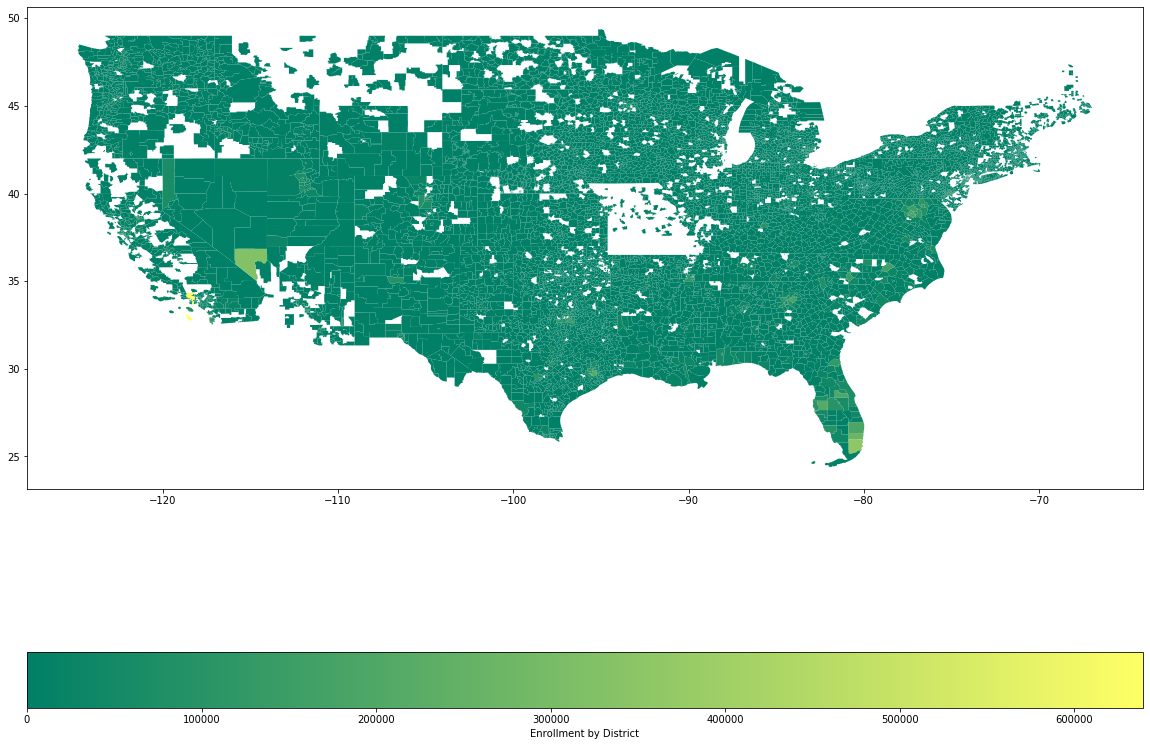

In [406]:
temp = finances_map_2016[~finances_map_2016.STATE.isin(['Alaska', 'Hawaii'])]
fig = temp.plot(column='ENROLL', cmap='summer', figsize = (20,20), legend=True, legend_kwds={'label': "Enrollment by District",
                                                                              'orientation': "horizontal"})


plt.show()

### Some Stuff?

In [407]:
SCHEMA = ['YRDATA',
'NAME',
'ENROLL',
'TOTALREV',
'TFEDREV',
'TSTREV',
'TLOCREV',
'LOCRTAX',
'LOCRPROP',
#'LOCREVPAR',
'PCTTOTAL',
'PCTFTOT',
'PCTSTOT',
'PCTLTOT',
'TOTALEXP',
'TCURSPND',
'TSALWAGE',
'TEMPBENE',
'TCURINST',
'TCURSSVC',
'PPCSTOT',
'PPITOTAL',
'PPSTOTAL']

def n_largest_or_smallest(df, n, operation):
    """Return a sorted df of the n most/least funded districts

        Parameters:
            df (dataframe): the dataframe to be modified
            n (int): the number of districts to keep
            operation (str)['smallest' or 'largest']: whether to return most/least funded 
        Returns:
            new_df (dataframe): A sorted dataframe of the n most/least funded districts in each state
    """
    
    if operation == 'largest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nlargest(n, columns='TOTALREV')) 
    elif operation == 'smallest':
        new_df = df.groupby(by='STATE')[SCHEMA].apply(lambda x: x.nsmallest(n, columns='TOTALREV'))
    else:
        print("operation must be 'largest' or 'smallest'")
        return
    
    return new_df

In [408]:
least_funded = n_largest_or_smallest(df_2016, 3, 'smallest')
most_funded = n_largest_or_smallest(df_2016, 3, 'largest')

least_funded.head()
most_funded.head()

NameError: name 'df_2016' is not defined